In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
import gammapy
import logging
import os
import numpy as np
import astropy.units as u
from matplotlib.colors import LogNorm
from gammapy.extern import xmltodict
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion, PixCoord
from gammapy.utils.energy import EnergyBounds
from gammapy.utils.fitting import Fit
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    models,
    FluxPointsEstimator,
    FluxPointsDataset,
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import ReflectedRegionsBackgroundEstimator, RingBackgroundEstimator
from gammapy.detect import TSMapEstimator, find_peaks
from gammapy.data import DataStore
from gammapy.spectrum.models import PowerLaw
print("numpy:", np.__version__)
print("astropy:", astropy.__version__)
print("gammapy:", gammapy.__version__)

numpy: 1.16.4
astropy: 3.1.2
gammapy: 0.12


In [3]:
SkyCoord.from_name("NGC253")

<SkyCoord (ICRS): (ra, dec) in deg
    (11.88805833, -25.2888)>

In [4]:
SkyCoord.from_name("Crab")

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>

In [5]:
from gammapy.data import EventList
path = "/home/rishank/events/Arp220_events_01.fits"
events = EventList.read(path)

In [6]:
events.table

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,631109006.8925086,-126.40474,23.511766,0.046293773,-0.48770356,-0.37113824,1
2,631109237.1347768,-126.4721,23.42641,0.033865355,-0.5728686,-0.4331898,1
3,631109248.9464204,-126.27872,23.590506,0.040891375,-0.40924335,-0.25542378,1
4,631109325.3829424,-126.05061,23.44664,0.05216276,-0.5533518,-0.04643234,1
5,631109374.8732121,-126.546,23.305622,0.047007244,-0.6934141,-0.50146174,1
6,631109401.6883066,-126.110886,23.345121,0.039894868,-0.6548384,-0.10181168,1
7,631109513.2986774,-126.18373,23.492966,0.037477355,-0.5069257,-0.1685047,1
8,631109516.4415705,-126.07367,23.57737,0.0563285,-0.42261246,-0.06752225,1


In [7]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)


In [8]:
os.environ['CALDB'] = '/home/rishank/gammapy-datasets/cta-1dc/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/gammapy-datasets/cta-1dc/caldb/
data


In [9]:
from pathlib import Path
path = Path("/home/rishank/events")
paths = list(path.rglob("Arp220*.fits"))
data_store = DataStore.from_events_files(paths)
observations = data_store.get_observations()
#from gammapy.data import DataStore
#path = "/home/rishank/M82_events.fits"
#data_store = DataStore.from_events_files([path])
#observations = data_store.get_observations()

In [10]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,TELESCOP,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
,deg,deg,deg,deg,deg,deg,deg,s,s,,s,s,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,str13,str13,str13,int64,str1,str3,str3,str13,str42,int64
2,234.0,24.0,37.52444646691623,52.91746687862045,0.0,90.0,0.0,259200.0,254016.0,0.98,631454469.18,631713669.18,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,0,,CTA,1dc,South_z20_50h,/home/rishank/events/Arp220_events_02.fits,13926695
1,234.0,24.0,37.52444646691623,52.91746687862045,0.0,90.0,0.0,259200.0,254016.0,0.98,631108869.18,631368069.18,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,0,,CTA,1dc,South_z20_50h,/home/rishank/events/Arp220_events_01.fits,13926695


In [11]:
is_gamma = events.table["MC_ID"] == 1
print("Number of events: ", len(events.table))
print("Number of gammas: ", is_gamma.sum())
print("Number of hadrons: ", len(events.table) - is_gamma.sum())

Number of events:  13926695
Number of gammas:  11013
Number of hadrons:  13915682


In [12]:
ra = events.table["RA"].data
dec = events.table["DEC"].data
print(ra.mean())
print(dec.mean())
gamma_ra = ra[is_gamma].mean()
print(gamma_ra)
gamma_dec = dec[is_gamma].mean()
print(gamma_dec)
d = SkyCoord(ra=-126.26159*u.degree, dec=23.503*u.degree, frame='icrs')
d.galactic

-126.00029
23.994793
-126.26159
23.503


<SkyCoord (Galactic): (l, b) in deg
    (36.62707102, 53.02845109)>

In [13]:
table = data_store.obs_table
c = SkyCoord(ra=table['RA_PNT'], dec=table['DEC_PNT'], frame='icrs')
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    [(37.52444647, 52.91746688), (37.52444647, 52.91746688)]>

<SkyCoord (Galactic): (l, b) in deg
    (37.52444647, 52.91746688)>

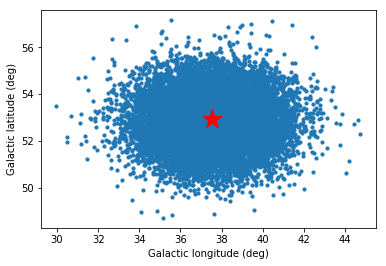

In [14]:
# Event positions
pos = events.galactic[::1000]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("180 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("180 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt

<SkyCoord (Galactic): (l, b) in deg
    (37.52444647, 52.91746688)>

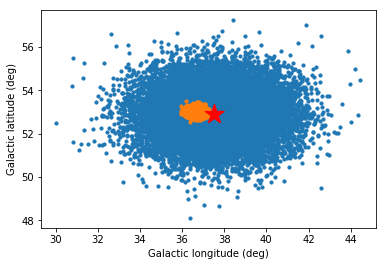

In [15]:
# Event positions
pos = events.galactic[~is_gamma][::1000]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("180 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("180 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt


#Event positions
pos = events.galactic[is_gamma][::1]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("180 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("180 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt

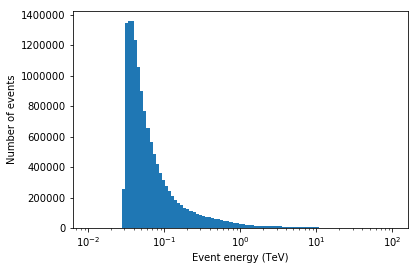

In [16]:
energy = events.table["ENERGY"].data
energy_bins = np.logspace(-2, 2, num=100)
plt.hist(energy, bins=energy_bins)
plt.semilogx()
plt.xlabel("Event energy (TeV)")
plt.ylabel("Number of events");

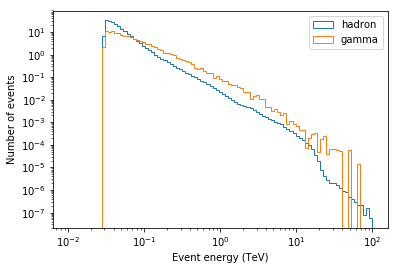

In [17]:
energy = events.table["ENERGY"].data
energy_bins = np.logspace(-2, 2, num=100)
opts = dict(bins=energy_bins, density=True, histtype="step")
plt.hist(energy[~is_gamma], label="hadron", **opts)
plt.hist(energy[is_gamma], label="gamma", **opts)
plt.loglog()
plt.xlabel("Event energy (TeV)")
plt.ylabel("Number of events")
plt.legend();

Text(0,0.5,'Offset (deg)')

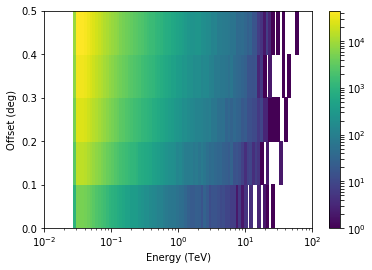

In [18]:

energy_bins = 10 ** np.linspace(-2, 2, 100)
offset_bins = np.arange(0, 0.6, 0.1)

t = events.table
offset = np.sqrt(t["DETX"] ** 2 + t["DETY"] ** 2)
hist = np.histogram2d(
    x=t["ENERGY"], y=offset, bins=(energy_bins, offset_bins)
)[0].T

plt.pcolormesh(energy_bins, offset_bins, hist, norm=LogNorm())
plt.semilogx()
plt.colorbar()
plt.xlabel("Energy (TeV)")
plt.ylabel("Offset (deg)")

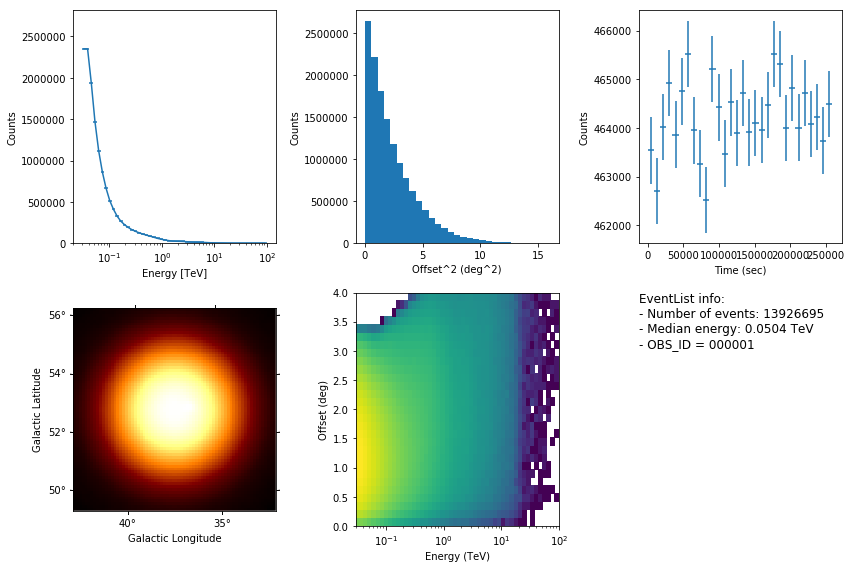

In [19]:
events.peek()

In [20]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(d.galactic.l.deg, d.galactic.b.deg), npix=(250, 200), binsz=0.02, coordsys="GAL", axes=[axis]
)
geom

WcsGeom

	axes       : lon, lat, energy
	shape      : (250, 200, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 36.6 deg, 53.0 deg
	width      : 5.0 deg x 4.0 deg

In [21]:
target_position = SkyCoord(d.galactic.l.deg, d.galactic.b.deg, unit="deg", frame="galactic")
on_radius = 0.1 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (250, 200)
	ndim  : 2
	unit  : '' 
	dtype : bool 



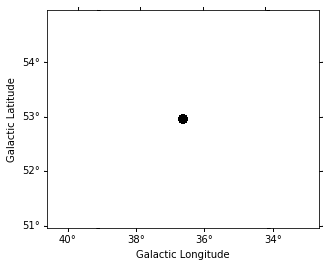

In [22]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
print(exclusion_mask)
exclusion_mask.plot();

CPU times: user 4min 21s, sys: 57.5 s, total: 5min 18s
Wall time: 5min 49s


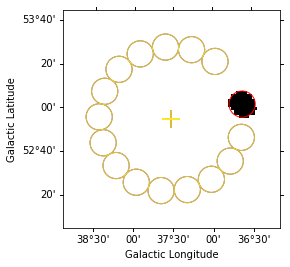

In [23]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot();

In [24]:
print('1\n',bkg_estimator.finder.reference_map.geom.wcs)
wcs = bkg_estimator.finder.reference_map.geom.wcs

print('2\n',bkg_estimator.finder.region.to_pixel(wcs))
bkg_estimator.finder._pix_region = bkg_estimator.finder.region.to_pixel(wcs)
print('3\n',bkg_estimator.finder._pix_region.radius)

bkg_estimator.finder._pix_center = PixCoord(*bkg_estimator.finder.center.to_pixel(wcs))
print('4',bkg_estimator.finder._pix_center.x)
print('5',bkg_estimator.finder.center.to_pixel(wcs))
print('6',bkg_estimator.finder._offset)
center = bkg_estimator.finder.center
print('7',bkg_estimator.finder.center)
print('8',bkg_estimator.finder.region.center)
print('9',bkg_estimator.finder.reference_map)
print('10',center)


1
 WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 37.52444646691623  52.91746687862045  
CRPIX : 42.0  42.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.02  0.02  
NAXIS : 83  83
2
 Region: CirclePixelRegion
center: PixCoord(x=67.98505163932762, y=46.71805391911047)
radius: 5.0002406383168685
3
 5.0002406383168685
4 41.0
5 (array(41.), array(41.))
6 27.584219267527494
7 <SkyCoord (ICRS): (ra, dec) in deg
    (234., 24.)>
8 <SkyCoord (Galactic): (l, b) in deg
    (36.62707102, 53.02845109)>
9 WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (83, 83)
	ndim  : 2
	unit  : '' 
	dtype : float32 

10 <SkyCoord (ICRS): (ra, dec) in deg
    (234., 24.)>


In [25]:
%%time
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(observations)
print(maps.keys())

dict_keys(['counts', 'exposure', 'background'])
CPU times: user 27.7 s, sys: 7.68 s, total: 35.4 s
Wall time: 58.3 s


In [26]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
images = maker.run_images()

excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

In [27]:
print(np.max(images["counts"].data))

492.0


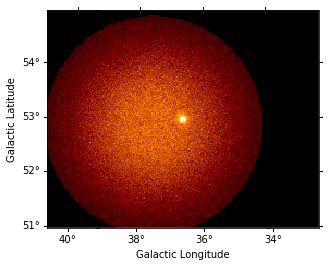

In [28]:
images["counts"].plot();

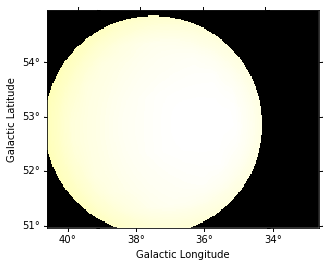

In [29]:
images["background"].plot();

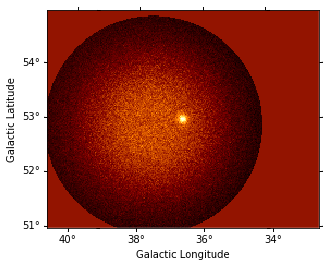

In [30]:
images["excess"].plot();

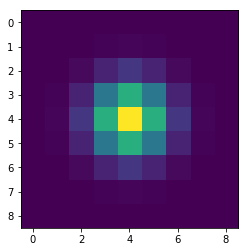

In [31]:
kernel = Gaussian2DKernel(1, mode="oversample").array
plt.imshow(kernel);

In [32]:
%%time
ts_image_estimator = TSMapEstimator()
images_ts = ts_image_estimator.run(images, kernel)
print(images_ts.keys())

dict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 489 ms, sys: 97 ms, total: 586 ms
Wall time: 5.41 s


In [33]:
sources = find_peaks(images_ts["sqrt_ts"], threshold=8)
sources

value,x,y,ra,dec
,,,deg,deg
float32,int64,int64,float64,float64
65,124,99,233.75169,23.51019
17.454,93,88,234.15419,24.05530
17.417,83,104,233.86962,24.32920
17.006,87,74,234.48415,24.10053
16.557,89,86,234.21868,24.12263
16.458,109,93,233.96035,23.77069
16.314,112,108,233.62653,23.78742
16.038,86,81,234.34133,24.15540


In [34]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(233.7516878 , 23.51019352), (234.15418635, 24.05529974),
     (233.86962445, 24.3292035 ), (234.48414925, 24.10053087),
     (234.21868283, 24.12262777), (233.96035461, 23.77069213),
     (233.62653205, 23.78742326), (234.34132718, 24.15539726),
     (234.08040529, 24.11414611), (234.118157  , 24.16718536),
     (233.79297569, 24.05807341), (233.70267078, 24.0586344 ),
     (234.27484435, 23.9232096 ), (234.01519995, 23.96430064),
     (234.28420909, 24.27238444), (233.57977702, 23.94289523),
     (234.37614115, 23.96100655), (234.01833314, 23.7362844 ),
     (233.83405357, 23.8831703 ), (234.34332627, 24.32030851),
     (233.78943478, 24.28608514), (234.54438953, 24.23082922),
     (233.93993268, 23.85816164), (233.77469798, 23.75258908),
     (234.08975786, 23.98794416), (233.7438713 , 23.88375567),
     (234.28665795, 23.56898251), (234.20029016, 23.89965584),
     (233.49089822, 24.19071116), (234.1634628 , 23.92909395),
     (234.01441862, 

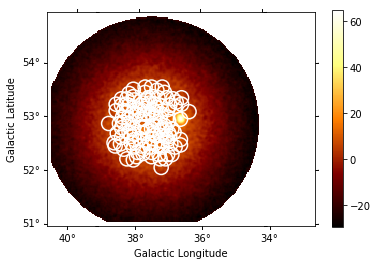

In [35]:
# Plot sources on top of significance sky image
images_ts["sqrt_ts"].plot(add_cbar=True)

plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
);

In [36]:
%%time
extract = SpectrumExtraction(
    observations=observations, bkg_estimate=bkg_estimate
)
extract.run()

CPU times: user 1.07 s, sys: 47.8 ms, total: 1.11 s
Wall time: 1.26 s


In [37]:
%%time
model = models.PowerLaw(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

for dataset in extract.spectrum_observations:
    dataset.model = model

fit = Fit(extract.spectrum_observations)
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 127
	total stat : 1560.18

CPU times: user 815 ms, sys: 0 ns, total: 815 ms
Wall time: 1.15 s


In [38]:
# Flux points are computed on stacked observation
from gammapy.spectrum import SpectrumDatasetOnOffStacker

stacker = SpectrumDatasetOnOffStacker(extract.spectrum_observations)
stacked_obs = stacker.run()

print(stacked_obs)

In [39]:
ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit=u.TeV)

stacked_obs.model = model

fpe = FluxPointsEstimator(datasets=[dataset], e_edges=ebounds)
flux_points = fpe.run()
flux_points.table_formatted


e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,loglike,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],dloglike_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.565,1.000,2.448,1.048e-13,1.540e-13,2.301e-13,2.566e-13,1.210,7.049,0.060,932,0.061,0.060,1.334,27.037,731.012,0.200 .. 5.000,452.8664497170985 .. 1769.6458275042569,1.268e-13,1.398e-13,6.332e-15,6.417e-15,6.248e-15
3.831,2.448,5.995,1.461e-14,5.258e-14,1.923e-13,2.145e-13,0.760,18.805,0.056,403,0.056,0.055,0.874,18.704,349.849,0.200 .. 5.000,172.18027938535602 .. 1839.491297282695,1.110e-14,1.278e-14,8.113e-16,8.238e-16,7.989e-16
10.000,5.995,16.681,1.771e-15,1.928e-14,1.815e-13,1.771e-13,0.410,14.462,0.062,116,0.064,0.060,0.541,8.701,75.714,0.200 .. 5.000,29.087813717818648 .. 1151.8299675463718,7.256e-16,9.573e-16,1.092e-16,1.125e-16,1.059e-16
26.102,16.681,40.842,2.145e-16,5.258e-15,1.310e-13,1.461e-13,0.526,3.501,0.101,32,0.107,0.095,0.752,10.021,100.428,0.200 .. 5.000,21.30208702460496 .. 366.9333351266367,1.128e-16,1.612e-16,2.158e-17,2.288e-17,2.032e-17


In [40]:
model.parameters.covariance = result.parameters.covariance
flux_points_dataset = FluxPointsDataset(data=flux_points, model=model)

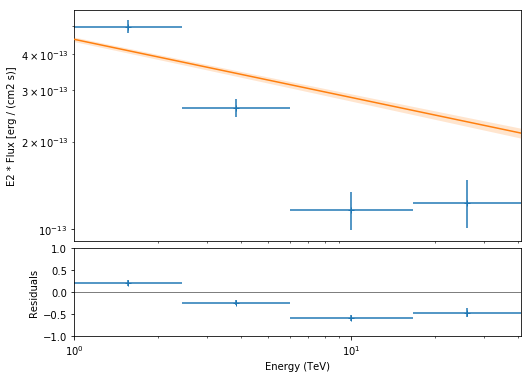

In [41]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();